In [1]:
%matplotlib widget

In [2]:
import flammkuchen as fl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import imageio
from scipy.stats import sem
import seaborn as sns
from bouter.free import FreelySwimmingExperiment
import pandas as pd
from scipy import signal
from tqdm import tqdm
from scipy.stats import zscore
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity as kde
from scipy.stats import linregress
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.stats import mannwhitneyu

In [3]:
def clip(x_):
    x_[x_>200]=200
    x_[x_<0]= 0
    return x_
def clean_augment(x_,stim_fun):
    out_ = []
    for df_ in x_:
        if "flip_x_start" in df_.keys():
            pass
        else:
            df_["flip_x_start"] = df_["al_start_x"]
            df_["flip_y_start"] = df_["al_start_y"]
            
            df_["flip_x_end"] = df_["al_end_x"]
            df_["flip_y_end"] = df_["al_end_y"]
        df_["flip_x_start"] = clip(df_["flip_x_start"].values)
        try:
            df_["flip_x_end"] = clip(df_["flip_x_end"].values)
        except:
            df_["flip_x_end"] = clip(df_["al_end_x"].values)
        out_.append(augment(df_,stim_fun))
    return out_

def clean_augment_cpca(x_,stim_fun):
    out_ = []
    for df_ in x_:
        df_["flip_x_start"] = abs(200-clip(df_["flip_x_start"].values))
        out_.append(augment(df_,stim_fun))
    return out_

def augment(bout_properties,fun,time_th=2):
    border_x = [10, 190]
    border_y = [5, 45]
    x_start = []
    x_end = []
    temp_start = []
    temp_end = []
    delta = []
    delta_prev = []
    out = []
    prev_biases = []
    prev_bout = None
    prev_bias = None
    prev_temp = None
    delta_prev_prev_bout = None
    delta_prev_bout = np.nan
    for i in range(len(bout_properties)):
        
        bout = bout_properties.iloc[i]
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if (temporal_distance <= time_th)& (delta_prev_bout!=np.nan):
                delta_prev_prev_bout = delta_prev_bout
            else:
                delta_prev_prev_bout  = np.nan
                
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if temporal_distance <= time_th:
                prev_bias = prev_bout["theta_bout"]
                delta_prev_bout = float(fun(prev_bout["flip_x_start"])) - float(fun(bout["flip_x_start"]))
            else:
                delta_prev_bout  = np.nan
                prev_bias = np.nan
                
            
        temp_start.append(float(fun(bout["flip_x_start"])))
        delta.append(delta_prev_bout)
        delta_prev.append(delta_prev_prev_bout)
        x_start.append(bout['flip_x_start'])
        prev_biases.append(prev_bias)
        if (border_x[0] <= bout["flip_x_start"] <= border_x[1]) and (border_y[0] <= bout["y_start"] <= border_y[1]):
            is_out = False
        else:
            is_out = True
        out.append(is_out)
        prev_bout = bout.copy()
    bout_properties["temp_start"] = temp_start
    bout_properties["delta"]=delta
    bout_properties["delta_1"]=delta_prev
    bout_properties["out"]=out
    bout_properties["prev_bias"]=prev_biases
    
    return bout_properties

def prefered_temperature(x_position,times,resolution=2):
    result = medfilt(np.interp(np.linspace(0,15*60,15*60*resolution),
            times,x_position),3)
    return np.nanmedian(result[600*resolution:])

def navigation_performance(x_position,times,function,resolution=2,setpoint=25,perc=50,from_=300):
    result = medfilt(np.interp(np.linspace(0,15*60,15*60*resolution),
            times,x_position),3)
    return np.sum(abs(function(result[from_*resolution:])-setpoint)<2)/(result.shape[0]-(from_*resolution))#np.percentile(abs(function(result[from_*resolution:])-setpoint),perc)

def time_occupancy_array(bs,pos_x, bins_space=np.linspace(0,200,50),bins_time=np.linspace(0,15*60,50)):
    out_ = np.zeros((bins_space.shape[0]-1,bins_time.shape[0]-1))
    for i_time,(s_time,e_time) in enumerate(zip(bins_time[:-1],bins_time[1:])):
        selected_bout = pos_x[(bs>=s_time)&(bs<e_time)]
        counts,_ = np.histogram(selected_bout,bins_space)
        counts  = counts/np.sum(counts)
        out_[:,i_time] = counts
    return out_

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
def time_occupancy_array(bs,pos_x, bins_space=np.linspace(0,200,50),bins_time=np.linspace(0,15*60,50)):
    pos_x = medfilt(np.interp(np.linspace(0,15*60,15*60*3),
            bs,pos_x),3)
    bs = np.linspace(0,15*60,15*60*3)
    out_ = np.zeros((bins_space.shape[0]-1,bins_time.shape[0]-1))
    for i_time,(s_time,e_time) in enumerate(zip(bins_time[:-1],bins_time[1:])):
        selected_bout = pos_x[(bs>=s_time)&(bs<e_time)]
        counts,_ = np.histogram(selected_bout,bins_space)
        counts  = counts/np.sum(counts)
        counts = (counts == np.nanmax(counts))*1
        out_[:,i_time] = counts
    return out_

def turn_fraction(x_):
    return np.sum(abs(x_)>np.deg2rad(30))/x_.shape[0]

In [4]:
plt.rcParams.update({'font.size': 25})

In [6]:
full_dataset = fl.load(r"Z:\experiments\virtual_gradients_experiments\freely_swim_Ruben\data.h5")
transfer_fun = interp1d(full_dataset["stimulus_calibration"][0,:],
                             full_dataset["stimulus_calibration"][1,:],
                             kind="quadratic")

WT = clean_augment(full_dataset["WT"].copy(),transfer_fun)
Hbpos_pre = clean_augment(full_dataset["Hbpos_pre_ablation"].copy(),transfer_fun)
Hbneg_post = clean_augment(full_dataset["Hbneg_post_ablation"].copy(),transfer_fun)
Hbpos_post = clean_augment(full_dataset["Hbpos_ablation"].copy(),transfer_fun)

In [7]:
twopabl_dataset = fl.load(r"Z:\experiments\virtual_gradients_experiments\data_2p_ablations.h5")
poa_abl = clean_augment(twopabl_dataset["poa"].copy(),transfer_fun)
ot_abl = clean_augment(twopabl_dataset["ot"].copy(),transfer_fun)

In [7]:
print(len(twopabl_dataset["poa"]),len(twopabl_dataset["ot"]))

20 20


In [6]:
deltaT = []
for i in np.linspace(0,199,500):
    delta = abs(transfer_fun(i)-transfer_fun(i+1))
    deltaT.append(delta)

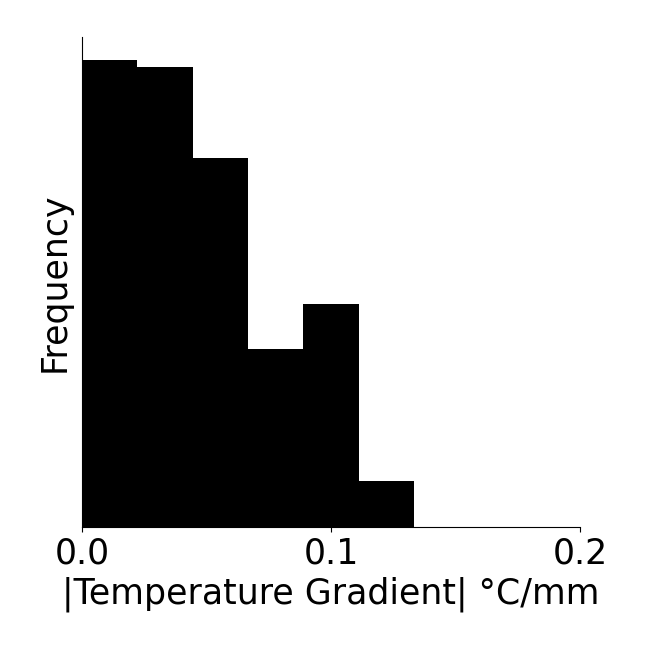

In [22]:
plt.figure()
plt.hist(deltaT,np.linspace(0,0.2,10),color="k")
plt.ylabel("Frequency",fontsize=25)
plt.xlabel("|Temperature Gradient| °C/mm",fontsize=25)
plt.yticks([])
plt.xticks([0,0.1,0.2],fontsize=25)
plt.xlim([0,0.2])
set_size(5,5)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_1_c.png",dpi=800)

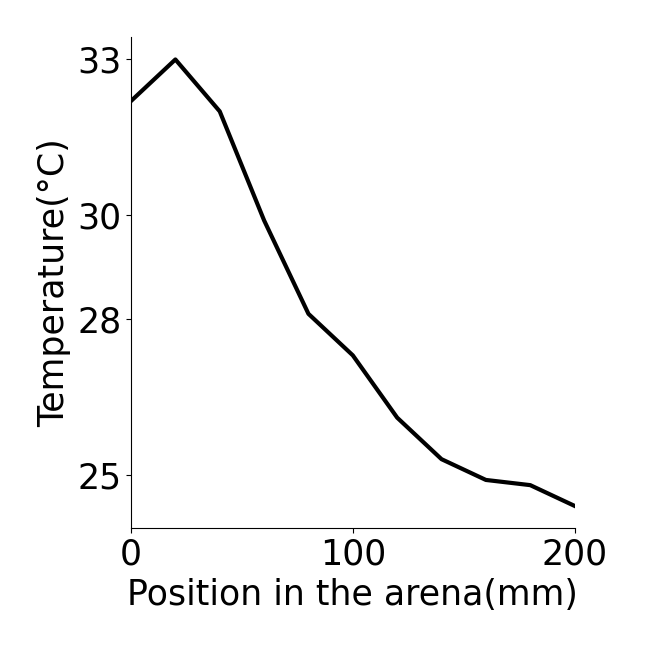

In [24]:
plt.figure(figsize=(10,5))
x_axis = np.linspace(0,200,500)
plt.plot(full_dataset["stimulus_calibration"][0,:],
         full_dataset["stimulus_calibration"][1,:],"k",lw=3)
plt.ylabel("Temperature(°C)",fontsize=25)
plt.xlabel("Position in the arena(mm)",fontsize=25)
plt.yticks([25,28,30,33],fontsize=25)
plt.xticks([0,100,200],fontsize=25)
plt.xlim([0,200])
set_size(5,5)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_1_b.png",dpi=800)

In [8]:
bins = np.linspace(0,200,50)
data_wt = []
for fish_ in WT:
    counts,_ = np.histogram(fish_["flip_x_start"],bins)
    rel_freq = counts / np.sum(counts)
    data_wt.append(rel_freq)
b = (bins[:-1]+bins[1:])/2

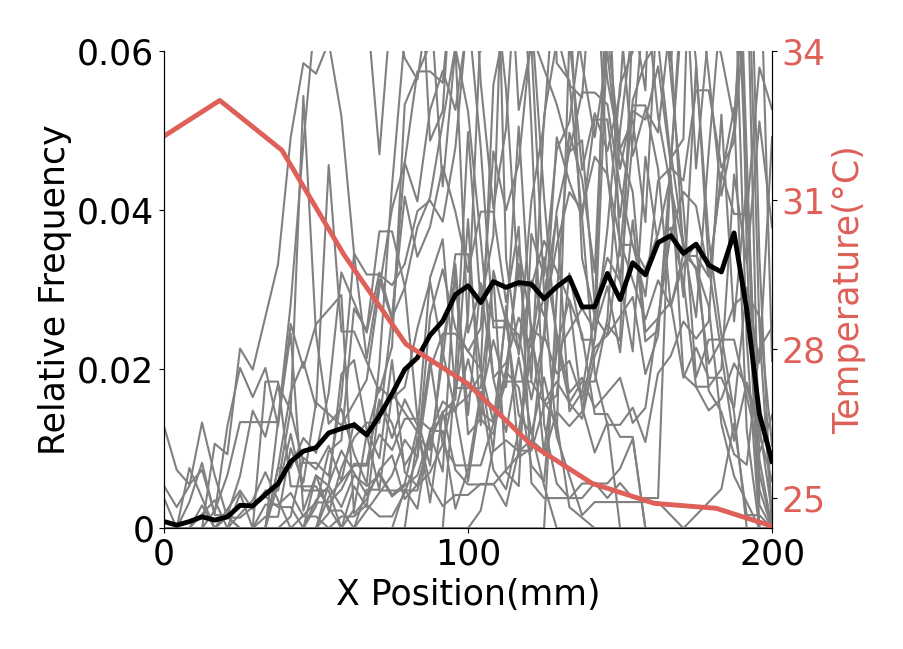

In [13]:
data_to_plot = np.stack(data_wt)
f,a = plt.subplots()
a2 = a.twinx()
a.plot(b,data_to_plot.T,c="gray",alpha=1,lw=1.5)
a.plot(b,np.nanmean(data_to_plot,0),c="k",alpha=1,lw=3.5)
a2.plot(full_dataset["stimulus_calibration"][0,:],
         full_dataset["stimulus_calibration"][1,:],c=(222/255,96/255,88/255),lw=3.5)
a.set_ylabel("Relative Frequency",fontsize=25)
a.set_xlabel("X Position(mm)",fontsize=25)
a.set_xticks([b[0],100,b[-1]])
a.set_xticklabels([0,100,200],fontsize=25)
a.set_yticks([0,.02,0.04,0.06])
a.set_yticklabels([0,.02,0.04,0.06],fontsize=25)
a.set_xlim([b[0],b[-1]])
a.set_ylim([0,0.06])

a2.set_ylim([np.min(full_dataset["stimulus_calibration"][1,:]),34])
a2.set_yticks([25,28,31,34])
a2.set_yticklabels([25,28,31,34],fontsize=25,c=(222/255,96/255,88/255))
a2.set_ylabel("Temperature(°C)",fontsize=25,c=(222/255,96/255,88/255))
set_size(7,5)
sns.despine(right=False)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\1_a.png",dpi=800)

In [14]:
dens_arrays = []
for f_ in WT:
    arr_ = (time_occupancy_array(f_["t_start"].values,
                                    f_["temp_start"].values,bins_space=np.linspace(24.4,33,20),
                                bins_time=np.linspace(0,15*60,60))>0)*1
    dens_arrays.append(arr_)

In [15]:
matrix = np.flip((np.sum(np.stack(dens_arrays,0),0)/len(dens_arrays)).T)

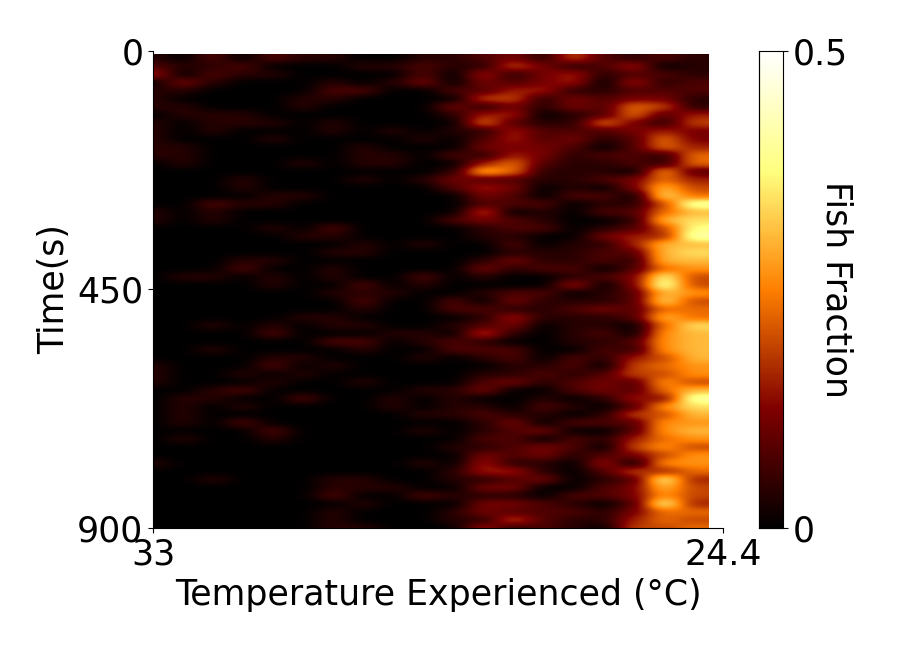

In [60]:
plt.figure()
plt.imshow(matrix,
           cmap="afmhot",interpolation="gaussian",
           vmin=0,vmax=.5,aspect="auto")

plt.xlabel("Temperature Experienced (°C)",fontsize=25)
plt.ylabel("Time(s)",fontsize=25)
plt.yticks([0,arr_.shape[1]/2,arr_.shape[1]],np.flip(np.array([0,int(7.5*60),15*60])),fontsize=25)
plt.xticks([0,arr_.shape[0]],[33,24.4],fontsize=25)
plt.xlim([0,arr_.shape[0]])
plt.ylim([0,arr_.shape[1]])
cbar = plt.colorbar()
cbar.ax.set_ylim([0,.5])
cbar.ax.set_yticks([0,.5])
cbar.ax.set_yticklabels([0,.5])
cbar.set_label('Fish Fraction', rotation=270,fontsize=25)
set_size(7,5)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_1_f.png",dpi=800)

In [29]:
n_bins = 50
dens_arrays = []
for f_ in WT:
    arr_ = (time_occupancy_array(f_["t_start"].values,
                                    f_["temp_start"].values,bins_space=np.array([24,26]),
                                bins_time=np.linspace(0,15*60,n_bins))>0)*1
    dens_arrays.append(arr_)

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: All-NaN slice encountered


In [30]:
matrix = np.flip((np.sum(np.stack(dens_arrays,0),0)/len(dens_arrays)).T)

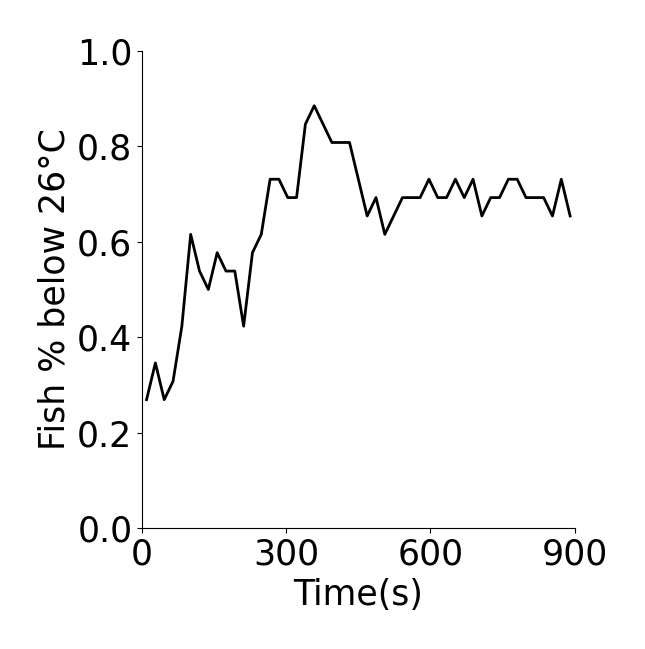

In [35]:
bins_plot = (np.linspace(0,15*60,n_bins)[1:] + np.linspace(0,15*60,n_bins)[:-1])/2
plt.figure()
plt.plot(bins_plot,np.flip(matrix[:,0]),"k",lw=2)
plt.xlabel("Time(s)",fontsize=25)
plt.ylabel("Fish % below 26°C",fontsize=25)
plt.yticks([0,.2,.4,.6,.8,1],fontsize=25)
plt.xticks([0,300,600,900],fontsize=25)
plt.xlim([0,900])
plt.ylim([0,1])
set_size(5,5)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_1_g.png",dpi=800)

In [8]:
pt_wt = []
for fish_ in WT:
        a = transfer_fun(prefered_temperature(fish_["flip_x_start"].values,
                              fish_["t_start"].values))
        pt_wt.append(a)
    
pt_Hbpos_pre = []
for fish_ in Hbpos_pre:
    a = transfer_fun(prefered_temperature(fish_["flip_x_start"].values,
                              fish_["t_start"].values))
    pt_Hbpos_pre.append(a)
    
pt_Hbneg_post = []
for fish_ in Hbneg_post:
    a = transfer_fun(prefered_temperature(fish_["flip_x_start"].values,
                              fish_["t_start"].values))
    pt_Hbneg_post.append(a)
    
pt_Hbpos_post = []
for fish_ in Hbpos_post:
    a = transfer_fun(prefered_temperature(fish_["flip_x_start"].values,
                              fish_["t_start"].values))
    pt_Hbpos_post.append(a)
    
pt_poa_abl = []
for fish_ in poa_abl:
    a = transfer_fun(prefered_temperature(fish_["flip_x_start"].values,
                              fish_["t_start"].values))
    pt_poa_abl.append(a)
    
pt_ot_abl = []
for fish_ in ot_abl:
    a = transfer_fun(prefered_temperature(fish_["flip_x_start"].values,
                              fish_["t_start"].values))
    pt_ot_abl.append(a)

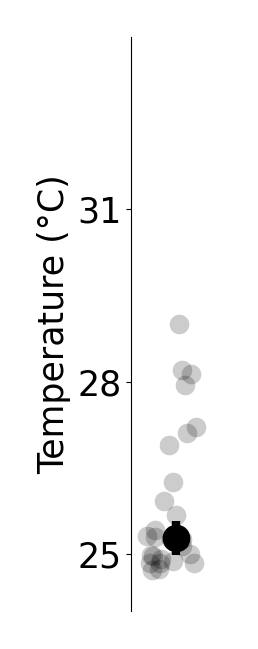

In [73]:
plt.figure()
to_plot = pt_wt.copy()
x_points = np.random.uniform(low=-1,high=1,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="k",lw=0)
plt.errorbar([0],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit")*1.2,
            lw=6,fmt="-",ms=13,marker="o",mew=7,c="k",
            capthick=5)
plt.ylim([24,34])
plt.xlim([-1.5,1.5])
plt.xticks([])
plt.yticks([25,28,31],fontsize=25)
plt.ylabel("Temperature (°C)",fontsize=25)
sns.despine(bottom=True)
set_size(2,5)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_1_d.png",dpi=800)

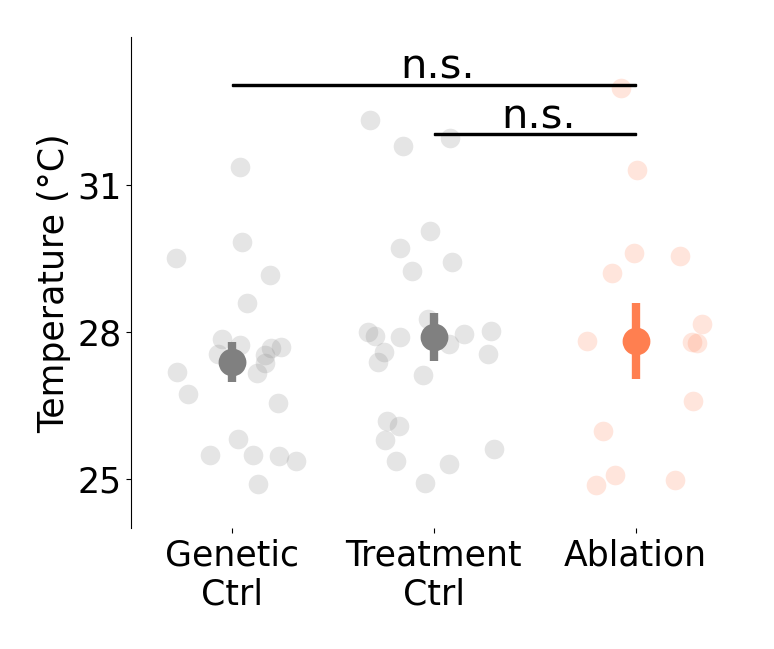

In [10]:
plt.figure()

to_plot = pt_Hbneg_post.copy()
x_points = np.random.uniform(low=-4,high=-2,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="gray",lw=0)
plt.errorbar([-3],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit")*1.2,
            lw=6,fmt="-",ms=13,marker="o",mew=7,c="gray",
            capthick=5)


to_plot = pt_Hbpos_pre.copy()

x_points = np.random.uniform(low=-1,high=1,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="gray",lw=0)
plt.errorbar([0],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit")*1.2,
            lw=6,fmt="-",ms=13,marker="o",mew=7,c="gray",
            capthick=5)

to_plot = pt_Hbpos_post.copy()

x_points = np.random.uniform(low=2,high=4,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="coral",lw=0)
plt.errorbar([3],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit")*1.2,
            lw=6,fmt="-",ms=13,marker="o",mew=7,c="coral",
            capthick=5)

plt.axvspan(-3,3,.9,.905,color="k")
plt.text(-0.5,33.15,"n.s.",color="k",fontsize=30)

plt.axvspan(0,3,.8,.805,color="k")
plt.text(1,32.15,"n.s.",color="k",fontsize=30)

plt.ylim([24,34])
plt.xlim([-4.5,4.5])
plt.xticks([-3,0,3],["Genetic\nCtrl","Treatment\nCtrl","Ablation"],fontsize=25)
plt.yticks([25,28,31],fontsize=25)
plt.ylabel("Temperature (°C)",fontsize=25)
set_size(6,5)
sns.despine(bottom=True)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\final_svgs\supp_6_c.png",dpi=800)

In [140]:
print(mannwhitneyu(pt_Hbpos_post,pt_Hbpos_pre))
print(mannwhitneyu(pt_Hbpos_post,pt_Hbneg_post))

MannwhitneyuResult(statistic=172.0, pvalue=0.47082646508051795)
MannwhitneyuResult(statistic=131.0, pvalue=0.17778694928232125)


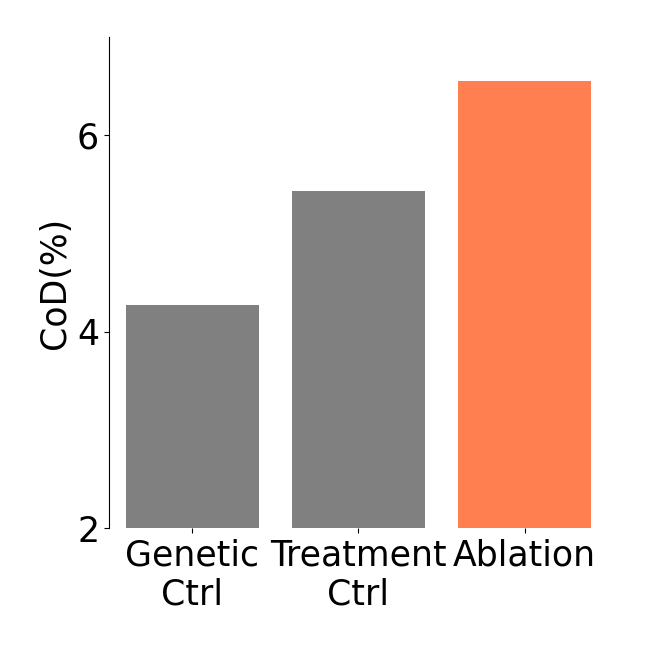

In [13]:
plt.figure()

to_plot = pt_Hbneg_post.copy()
to_plot = ((np.sum(abs(to_plot-np.nanmedian(to_plot)))/np.nanmedian(to_plot))/len(to_plot))*100
plt.bar([0],to_plot,color="gray")


to_plot = pt_Hbpos_pre.copy()
to_plot = ((np.sum(abs(to_plot-np.nanmedian(to_plot)))/np.nanmedian(to_plot))/len(to_plot))*100
plt.bar([1],to_plot,color="gray")

to_plot = pt_Hbpos_post.copy()
to_plot = ((np.sum(abs(to_plot-np.nanmedian(to_plot)))/np.nanmedian(to_plot))/len(to_plot))*100
plt.bar([2],to_plot,color="coral")

    
plt.ylim([2,7])
plt.xlim([-.5,2.5])
plt.xticks([0,1,2],["Genetic\nCtrl","Treatment\nCtrl","Ablation"],fontsize=25)
plt.yticks([2,4,6],fontsize=25)
plt.ylabel("CoD(%)",fontsize=25)
set_size(5,5)

sns.despine(bottom=True)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\final_svgs\supp_6_e.png",dpi=800)

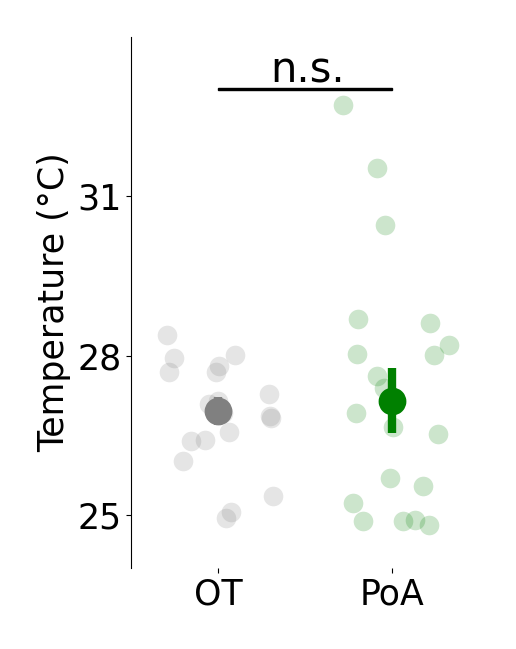

In [139]:
plt.figure()

to_plot = pt_ot_abl.copy()
x_points = np.random.uniform(low=-4,high=-2,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="gray",lw=0)
plt.errorbar([-3],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit")*1.2,
            lw=6,fmt="-",ms=13,marker="o",mew=7,c="gray",
            capthick=5)


to_plot = pt_poa_abl.copy()
x_points = np.random.uniform(low=-1,high=1,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="green",lw=0)
plt.errorbar([0],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit")*1.2,
            lw=6,fmt="-",ms=13,marker="o",mew=7,c="green",
            capthick=5)

plt.axvspan(-3,0,.9,.905,color="k")
plt.text(-2.1,33.15,"n.s.",color="k",fontsize=30)



plt.ylim([24,34])
plt.xlim([-4.5,1.5])
plt.xticks([-3,0],["OT","PoA"],fontsize=25)
plt.yticks([25,28,31],fontsize=25)
plt.ylabel("Temperature (°C)",fontsize=25)
sns.despine(bottom=True)
set_size(4,5)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_5_b.png",dpi=800)

In [127]:
print(mannwhitneyu(pt_poa_abl,pt_ot_abl))

MannwhitneyuResult(statistic=185.0, pvalue=0.34744550993388323)


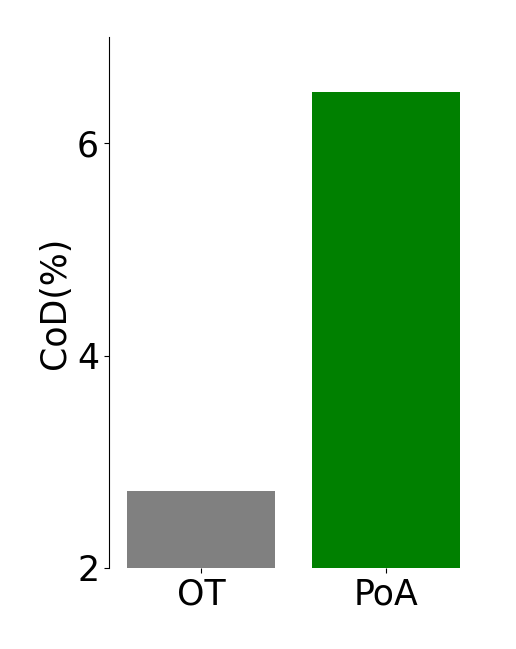

In [88]:
plt.figure()

to_plot = pt_ot_abl.copy()
to_plot = ((np.sum(abs(to_plot-np.nanmedian(to_plot)))/np.nanmedian(to_plot))/len(to_plot))*100
plt.bar([0],to_plot,color="gray")


to_plot = pt_poa_abl.copy()
to_plot = ((np.sum(abs(to_plot-np.nanmedian(to_plot)))/np.nanmedian(to_plot))/len(to_plot))*100
plt.bar([1],to_plot,color="green")

plt.ylim([2,7])
plt.xlim([-.5,1.5])
plt.xticks([0,1],["OT","PoA"],fontsize=25)
plt.yticks([2,4,6],fontsize=25)
plt.ylabel("CoD(%)",fontsize=25)
set_size(4,5)

sns.despine(bottom=True)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_5_c.png",dpi=800)

In [15]:
n_turns_Hbpos_pre = []
for fish_ in Hbpos_pre:
    a = turn_fraction(fish_["theta_bout"].values)
    n_turns_Hbpos_pre.append(a)
    
n_turns_Hbneg_post = []
for fish_ in Hbneg_post:
    a = turn_fraction(fish_["theta_bout"].values)
    n_turns_Hbneg_post.append(a)
    
n_turns_Hbpos_post = []
for fish_ in Hbpos_post:
    a = turn_fraction(fish_["theta_bout"].values)
    n_turns_Hbpos_post.append(a)
    
n_turns_poa_abl = []
for fish_ in poa_abl:
    a = turn_fraction(fish_["theta_bout"].values)
    n_turns_poa_abl.append(a)
    
n_turns_ot_abl = []
for fish_ in ot_abl:
    a = turn_fraction(fish_["theta_bout"].values)
    n_turns_ot_abl.append(a)

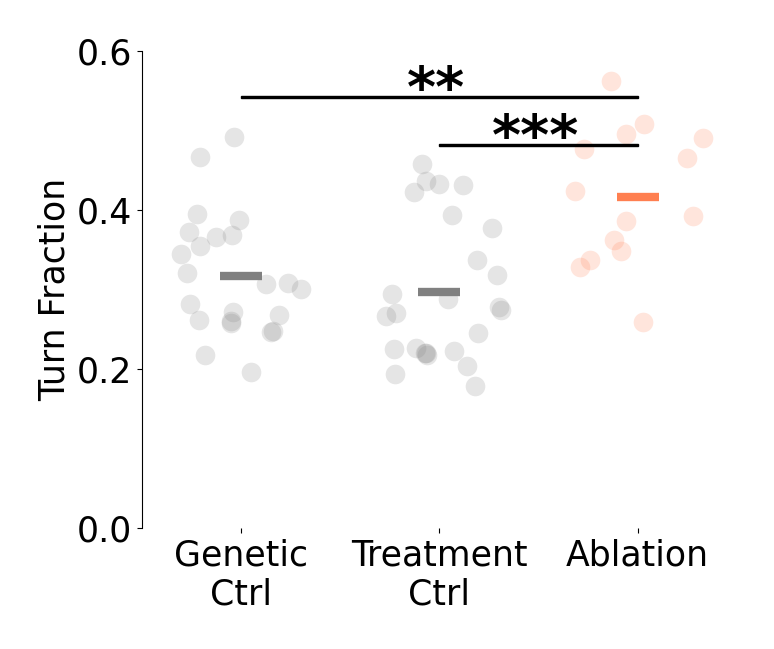

In [16]:
plt.figure()
to_plot = n_turns_Hbneg_post.copy()
x_points = np.random.uniform(low=-4,high=-2,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="gray",linewidths=0)
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            lw=12,fmt="-",ms=30,marker="_",mew=6,c="gray",
            capthick=5)


to_plot = n_turns_Hbpos_pre.copy()
x_points = np.random.uniform(low=-1,high=1,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="gray",linewidths=0)
plt.errorbar([0],y=np.array([np.nanmean(to_plot)]),
            lw=12,fmt="-",ms=30,marker="_",mew=6,c="gray",
            capthick=5)

to_plot = n_turns_Hbpos_post.copy()
x_points = np.random.uniform(low=2,high=4,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="coral",linewidths=0)
plt.errorbar([3],y=np.array([np.nanmean(to_plot)]),
            lw=12,fmt="-",ms=30,marker="_",mew=6,c="coral",
            capthick=5)

plt.axvspan(-3,3,.9,.905,color="k")
plt.text(-0.5,0.53,"**",color="k",fontsize=40,fontweight="bold")

plt.axvspan(0,3,.8,.805,color="k")
plt.text(.8,0.47,"***",color="k",fontsize=40,fontweight="bold")


plt.ylim([0.1,.6])
plt.xlim([-4.5,4.5])
plt.xticks([-3,0,3],["Genetic\nCtrl","Treatment\nCtrl","Ablation"],fontsize=25)
plt.yticks([0,.2,.4,.6],fontsize=25)
plt.ylabel("Turn Fraction",fontsize=25)
set_size(6,5)

sns.despine(bottom=True)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\final_svgs\supp_6_d.png",dpi=800)

In [101]:
print(mannwhitneyu(n_turns_Hbpos_post,n_turns_Hbpos_pre))
print(mannwhitneyu(n_turns_Hbpos_post,n_turns_Hbneg_post))

MannwhitneyuResult(statistic=61.0, pvalue=0.00044537075807845797)
MannwhitneyuResult(statistic=64.0, pvalue=0.0012554447371753402)


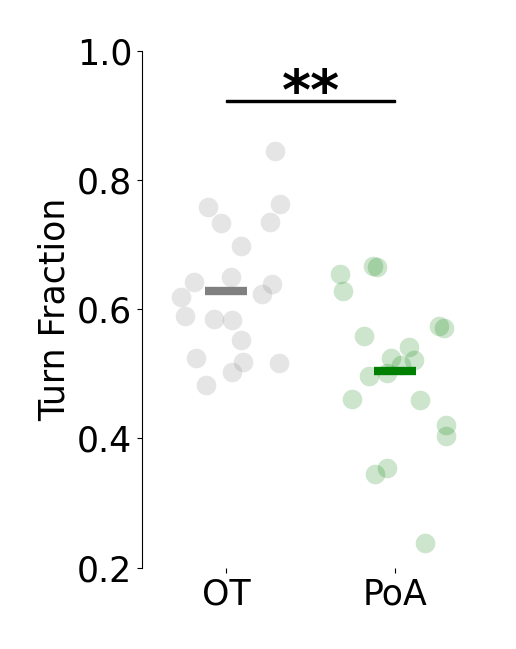

In [145]:
plt.figure(figsize=(3,6))

to_plot = n_turns_ot_abl.copy()
x_points = np.random.uniform(low=-4,high=-2,size=(len(to_plot)))
plt.scatter(x_points,to_plot,s=200,alpha=.2,c="gray",linewidths=0)
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            lw=12,fmt="-",ms=30,marker="_",mew=6,c="gray",
            capthick=5)

to_plot = n_turns_poa_abl.copy()
x_points = np.random.uniform(low=-1,high=1,size=(len(to_plot)))

plt.scatter(x_points,to_plot,s=200,alpha=.2,c="green",linewidths=0)
plt.errorbar([0],y=np.array([np.nanmean(to_plot)]),
            lw=12,fmt="-",ms=30,marker="_",mew=6,c="green",
            capthick=5)


plt.axvspan(-3,0,.9,.905,color="k")
plt.text(-2,0.91,"**",color="k",fontsize=40,fontweight="bold")

plt.ylim([0.2,.9])
plt.xlim([-4.5,1.5])
plt.xticks([-3,0],["OT","PoA"],fontsize=25)
plt.yticks([.2,.4,.6,.8,1])
plt.ylabel("Turn Fraction",fontsize=25)
sns.despine(bottom=True)
set_size(4,5)
plt.tight_layout()
plt.show()

plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_5_d.png",dpi=800)

In [107]:
print(mannwhitneyu(n_turns_ot_abl,n_turns_poa_abl))

MannwhitneyuResult(statistic=88.0, pvalue=0.0012803076435722936)
